# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

dog_files_training = len(np.array(glob("dogImages/train/*/*"))) / len(dog_files)
dog_files_valid = len(np.array(glob("dogImages/valid/*/*"))) / len(dog_files)
dog_files_test = len(np.array(glob("dogImages/test/*/*"))) / len(dog_files)

folders = ['train', 'valid', 'test']

y_pos = np.arange(len(folders))
dog_files_length = [dog_files_training, dog_files_valid, dog_files_test]

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8350 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


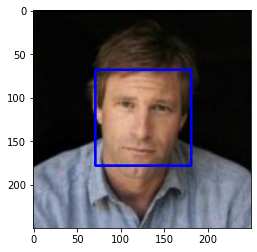

In [32]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [2]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [34]:
from tqdm import tqdm

human_files_short = human_files
dog_files_short = dog_files

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
ident_human = 0
ident_dog = 0
for img in tqdm(human_files_short):
    ident_human += face_detector(img)

for img in tqdm(dog_files_short):
    ident_dog += face_detector(img)
    
print("{}% of human faces where detected as such whereas {}% of dog images where interpreted as human faces.".format((ident_human/len(human_files_short)*100), (ident_dog/len(dog_files_short)*100)))

100%|██████████| 8350/8350 [08:38<00:00, 16.10it/s]

98.71533287992142% of human faces where detected as such whereas 10.970059880239521% of dog images where interpreted as human faces.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [3]:
import torch
import torchvision.models as models
from torchsummary import summary

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
summary(VGG16, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [4]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # check if cuda is available
    # Use GPU if it's available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    VGG16.to(device)
    
    # first, process image
    img_processed = process_image(img_path)
    
    # return is numpy array. Converting to pytorch tensor of float type
    img_processed = torch.tensor(img_processed).float()
    
    # tensor still in 3d -> expects stacked 4d tensor
    im_tensor = []
    im_tensor.append(img_processed)
    im_tensor = torch.stack(im_tensor)
    
    with torch.no_grad():
        
        # evaluation mode
        VGG16.eval()
        im_tensor = im_tensor.to(device)
        logps = VGG16.forward(im_tensor)
        
        # getting index of prediction as int
        index = torch.max(logps, 1).indices
    return int(index)

def process_image(image):

#   importing image and resizing it keeping aspect ratio
    im = Image.open(image)
    
    # checking for height and width to see which side is longer
    width , height = im.size
    
    if width > height:
        im.thumbnail((9999, 256))
    else:
        im.thumbnail((256, 9999))

    # pick up new width, height    
    width , height = im.size

    # defining size of cropped image
    crop = 224
    
    # cropping based on expected size
    left = (width - crop) / 2
    top = (height - crop) / 2
    right = (width + crop) / 2
    bottom = (height + crop) / 2
        
    im = im.crop((left, top, right, bottom))
    
    # converting to numpy array and converting to numbers between 0 and 1
    np_image = np.array(im) / 255

    # mean
    means = np.array([0.485, 0.456, 0.406])
    # std
    std = np.array([0.229, 0.224, 0.225])

    # normalizing
    np_image = (np_image - means) / std
    
    # transposing tensor to match pytorch expectations
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [5]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    is_dog = False
    index = VGG16_predict(img_path)
#     print(index)
    if 151 <= index <= 268:
        is_dog = True
    else:
        is_dog = False
        
    return is_dog # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [38]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm

#-#-# Do NOT modify the code above this line. #-#-#

ident_human = 0
ident_dog = 0
for img in tqdm(human_files):
    ident_human += dog_detector(img)

for img in tqdm(dog_files):
    ident_dog += dog_detector(img)
    
print("{:.1f}% of human faces where falsely detected as dogs whereas {:.1f}% of dog images where interpreted correctly.".format((ident_human/len(human_files)*100), (ident_dog/len(dog_files)*100)))

100%|██████████| 8350/8350 [03:09<00:00, 44.17it/s]

0.6% of human faces where falsely detected as dogs whereas 99.1% of dog images where interpreted correctly.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [6]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# paths to directories
train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'
test_dir = 'dogImages/test'

## Specify appropriate transforms, and batch_sizes
# train transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# valid transforms
valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# test transforms
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32,  num_workers=12, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,  num_workers=12, pin_memory=True)

loaders_scratch = {"train" : trainloader,
                  "valid" : validloader,
                  "test" : testloader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
The code resizes and crops the image to a size of 224*224. It does so by randomly resizing it and cropping it down to the specified output (for the training data).
I decided on those values, at they are expected by VGG16. It will be useful, when I will apply transfer learning on this basis later.
For augemtation, I used random rotation, as the images are not expected to be homogenous when it comes to perspective. Also, I choose to randomly flip the images horizontaly if there should be an imbalance in the training data again when it comes to the perspective (for example images of dogs are more often left to right, left beeing the tail then right to left. I want to avoid the network learning this behavior as it doesn't have anything to do with the dog and it's recognition.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [40]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        self.conv3 = nn.Conv2d(12, 24, 3, padding=1)
        self.conv4 = nn.Conv2d(24, 48, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(48*14*14, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 133)
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = x.view(-1, 48*14*14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [41]:
# see summary of CNN

summary(model_scratch, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 224, 224]         168
├─MaxPool2d: 1-2                         [-1, 6, 112, 112]         --
├─Conv2d: 1-3                            [-1, 12, 112, 112]        660
├─MaxPool2d: 1-4                         [-1, 12, 56, 56]          --
├─Conv2d: 1-5                            [-1, 24, 56, 56]          2,616
├─MaxPool2d: 1-6                         [-1, 24, 28, 28]          --
├─Conv2d: 1-7                            [-1, 48, 28, 28]          10,416
├─MaxPool2d: 1-8                         [-1, 48, 14, 14]          --
├─Linear: 1-9                            [-1, 8192]                77,078,528
├─Dropout: 1-10                          [-1, 8192]                --
├─Linear: 1-11                           [-1, 1024]                8,389,632
├─Dropout: 1-12                          [-1, 1024]                --
├─Linear: 1-13                           [-1, 133]           

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 224, 224]         168
├─MaxPool2d: 1-2                         [-1, 6, 112, 112]         --
├─Conv2d: 1-3                            [-1, 12, 112, 112]        660
├─MaxPool2d: 1-4                         [-1, 12, 56, 56]          --
├─Conv2d: 1-5                            [-1, 24, 56, 56]          2,616
├─MaxPool2d: 1-6                         [-1, 24, 28, 28]          --
├─Conv2d: 1-7                            [-1, 48, 28, 28]          10,416
├─MaxPool2d: 1-8                         [-1, 48, 14, 14]          --
├─Linear: 1-9                            [-1, 8192]                77,078,528
├─Dropout: 1-10                          [-1, 8192]                --
├─Linear: 1-11                           [-1, 1024]                8,389,632
├─Dropout: 1-12                          [-1, 1024]                --
├─Linear: 1-13                           [-1, 133]           

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
Experimenting with different depths I ended up using 4 layers of convolution followed by max pooling in order to bring down the size of the matrices and trying to generalize the output. Also, max-pooling reduces computation overhead, as the matrices are smaller. It seems to be a tradeoff between depth of the network and processing time. Also additional layers did not generally lead to a better performance. The convolution layers are followed by a 3 step dense layout that brings the flattened tensor of size 8192 to 1024 and finally 133 that corresponds to the classes.
Dropout is used after each linear stage to avoid training only specific nodes.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [42]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [43]:
# the following import is required for training to be robust to truncated images
import time
import pickle
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# saving training loss and validation loss during compute
trainLossList = []
validLossList = []

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    startTime = time.time()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # forward + backward + optimize
            
            # zeroing gradients
            optimizer.zero_grad()
            
            # forward pass
            logps = model.forward(data)
            
            # computing loss function
            loss = criterion(logps, target)
            
            # backprop through netword
            loss.backward()
            
            # optimize weights
            optimizer.step()
            
            # record training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
               
        # model in eval mode
        model.eval()
        
        # no gradients are calculated in forward pass.
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                
                # forward pass with valid data
                logps = model.forward(data)
                
                # saving valid_loss
                loss = criterion(logps, target)
                
                # update the average validation loss
                valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics
        trainLossList.append(train_loss.cpu().numpy())
        validLossList.append(valid_loss.cpu().numpy())
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        print('time spent: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time.time()-startTime))))
        startTime = time.time()      
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print("valid loss has decreased from {:.3f} to {:.3f}".format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    metricsObj = {'train_loss': trainLossList, 'valid_loss': validLossList}
    return model, metricsObj

In [ ]:
# train the model
model_scratch, metrics = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch_final_{}.pt'.format(time.strftime("%d_%m_%y_%H_%M")))

# dump metrics to file
with open('metrics_obj_' + str(time.strftime("%d_%m_%y_%H_%M")) +'.obj', 'wb') as f:
    pickle.dump(metrics, f)

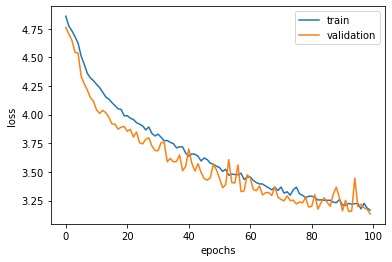

In [44]:
import pickle
with open('metrics_obj_29_01_21_13_36.obj', 'rb') as f:
    metrics_loaded = pickle.load(f)
    
plt.plot(metrics_loaded['train_loss'][:100], label='train')
plt.plot(metrics_loaded['valid_loss'][:100], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc="upper right")
plt.show()


In [45]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_final_29_01_21_12_46.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [46]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.111458


Test Accuracy: 25% (209/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [7]:
## TODO: Specify data loaders
# Already specified dataloaders with VGG16 in mind (normalisation, size etc.)
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [8]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# Using VGG16 including output dense layer. Only change is in out_features. Replacing last stage to be 133 stages.
# Only training classifier
model_transfer = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available

if use_cuda:
    VGG16 = VGG16.cuda()
    
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False


model_transfer.classifier[-1] = nn.Linear(in_features=4096, out_features=133)

# classifier is trained completely
for param in model_transfer.classifier.parameters():
    param.requires_grad = True

summary(model_transfer, (3, 224, 224))
    
if use_cuda:
    model_transfer = model_transfer.cuda()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
VGG-16 implements an output dense layer that consists of 1000 ouput classes as last step. In our case, we are only interested in 133 classes. I kept the classifier the same and only changing the output stage from 1000 output classes to 133 classes. A fully customized approch for the complete classifier didn't result in better outcome, so I kept the implementation as close to original with good results.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [9]:
# defining criterion and optimizer used
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [10]:
# train the model
model_transfer, objects = train(50, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_final.pt')

Epoch: 1 	Training Loss: 2.571431 	Validation Loss: 0.677987
time spent: 00:01:10
valid loss has decreased from inf to 0.678
Epoch: 2 	Training Loss: 1.338873 	Validation Loss: 0.499789
time spent: 00:01:12
valid loss has decreased from 0.678 to 0.500
Epoch: 3 	Training Loss: 1.180776 	Validation Loss: 0.463182
time spent: 00:01:13
valid loss has decreased from 0.500 to 0.463
Epoch: 4 	Training Loss: 1.091402 	Validation Loss: 0.445835
time spent: 00:01:11
valid loss has decreased from 0.463 to 0.446
Epoch: 5 	Training Loss: 1.017511 	Validation Loss: 0.425427
time spent: 00:01:12
valid loss has decreased from 0.446 to 0.425
Epoch: 6 	Training Loss: 0.992448 	Validation Loss: 0.410154
time spent: 00:01:13
valid loss has decreased from 0.425 to 0.410
Epoch: 7 	Training Loss: 0.942985 	Validation Loss: 0.385747
time spent: 00:01:14
valid loss has decreased from 0.410 to 0.386
Epoch: 8 	Training Loss: 0.920637 	Validation Loss: 0.392055
time spent: 00:01:13
Epoch: 9 	Training Loss: 0.9245

In [11]:
# dump metrics to file
with open('metrics_transfer_obj_' + str(time.strftime("%d_%m_%y_%H_%M")) +'.obj', 'wb') as f:
    pickle.dump(objects, f)

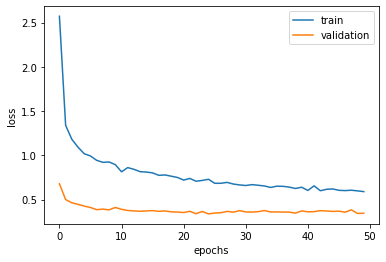

In [19]:
plt.plot(objects['train_loss'], label='train')
plt.plot(objects['valid_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer_50_epochs.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [30]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.437650


Test Accuracy: 87% (731/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [47]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_transfer.to(device)
    
    # first, process image
    img_processed = process_image(img_path)
    
    # return is numpy array. Converting to pytorch tensor of float type
    img_processed = torch.tensor(img_processed).float()
    
    # tensor still in 3d -> expects stacked 4d tensor
    im_tensor = []
    im_tensor.append(img_processed)
    im_tensor = torch.stack(im_tensor)
    
    with torch.no_grad():
        
        # evaluation mode
        model_transfer.eval()
        im_tensor = im_tensor.to(device)
        logps = model_transfer.forward(im_tensor)
        # getting index of prediction as int
        index = torch.max(logps, 1).indices
    return class_names[index]

#testing it
print(predict_breed_transfer(dog_files[2000]))

Belgian malinois


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [48]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    # first, run image through standard VGG16 to detect dog vs human
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) == True:
        print('Detected a dog from file: {}'.format(img_path))
        # run through dog breed classification
        dog_breed = predict_breed_transfer(img_path)
        print('The breed seems to be: {}'.format(dog_breed))
    else:
        # if no dog is detected, then run it through the face algorithm
        if face_detector(img_path) == True:
            human_dog_breed = predict_breed_transfer(img_path)
            print('Detected a human face! You look like a {}!'.format(human_dog_breed))
        else:
            print('No human or dog was detected in the image!')
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ <br>The output is very accurate. It seems to perform well. <br>possible improvements:
- Increase amount of images to have a wider variety to train on. Especially the transfere learning approach could benefit from it as it validiation loss couldn't decrease anymore
- Choose a different pre-trained netword. Possibly a different pre-trained network might perform even better on inference. 
- Using a different image augmentation scheme to add variablity

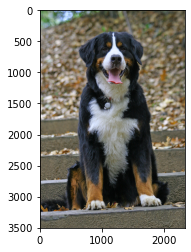

Detected a dog from file: testImages\123e03f0cc15116bd2642a847e9edad8.jpg
The breed seems to be: Greater swiss mountain dog


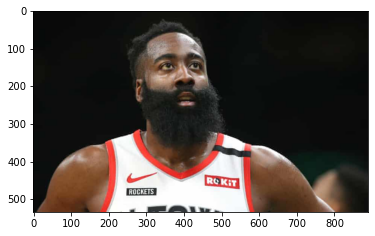

Detected a human face! You look like a Dachshund!


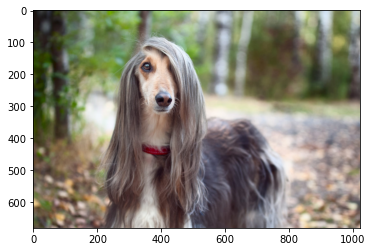

Detected a dog from file: testImages\afghan-hound-hair-colour-1024x681.jpg
The breed seems to be: Afghan hound


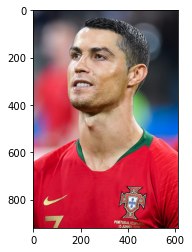

Detected a human face! You look like a Xoloitzcuintli!


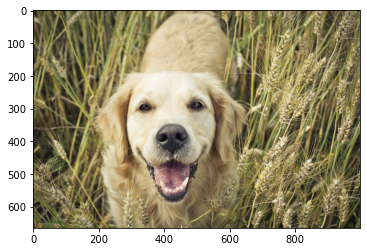

Detected a dog from file: testImages\Golden-Retriever.jpg
The breed seems to be: Golden retriever


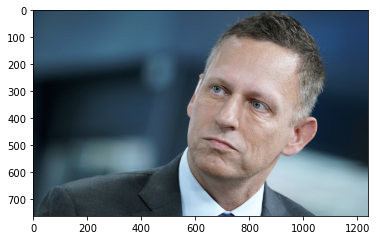

Detected a human face! You look like a Welsh springer spaniel!


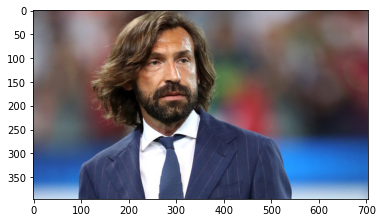

Detected a human face! You look like a Welsh springer spaniel!


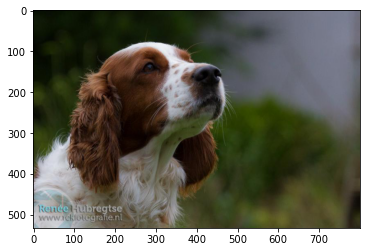

Detected a dog from file: testImages\Welsh_Springer_Spaniel.jpg
The breed seems to be: Welsh springer spaniel


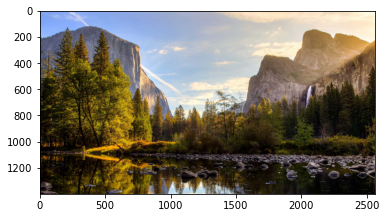

No human or dog was detected in the image!


In [49]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
test_files = np.array(glob('testImages/*'))
for file in np.hstack((test_files)):
    run_app(file)